In [1]:
# importing all necessary libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib as mpl
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor

In [2]:
import warnings  # to remove all the python warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('Dataset/Bengaluru_House_Data.csv')
df.head(10)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00
5,Super built-up Area,Ready To Move,Whitefield,2 BHK,DuenaTa,1170,2.0,1.0,38.00
6,Super built-up Area,18-May,Old Airport Road,4 BHK,Jaades,2732,4.0,NaN,204.00
7,Super built-up Area,Ready To Move,Rajaji Nagar,4 BHK,Brway G,3300,4.0,NaN,600.00
8,Super built-up Area,Ready To Move,Marathahalli,3 BHK,NaN,1310,3.0,1.0,63.25
9,Plot Area,Ready To Move,Gandhi Bazar,6 Bedroom,NaN,1020,6.0,NaN,370.00


### About the dataset

Buying a home, especially in a city like Bengaluru, is a tricky choice. While the major factors are usually the same for all metros, there are others to be considered for the Silicon Valley of India. With its help millennial crowd, vibrant culture, great climate and a slew of job opportunities, it is difficult to ascertain the price of a house in Bengaluru.

In [4]:
df.shape # to find total number of rows and columns in dataset

(13320, 9)

In [5]:
df.groupby('area_type')['area_type'].agg('count')  # to find out various types of area along with their count

area_type
Built-up  Area          2418
Carpet  Area              87
Plot  Area              2025
Super built-up  Area    8790
Name: area_type, dtype: int64

In [6]:
df.describe()

,bath,balcony,price
count,13247.000000,12711.000000,13320.000000
mean,2.692610,1.584376,112.565627
std,1.341458,0.817263,148.971674
min,1.000000,0.000000,8.000000
25%,2.000000,1.000000,50.000000
50%,2.000000,2.000000,72.000000
75%,3.000000,2.000000,120.000000
max,40.000000,3.000000,3600.000000


Assuming that area_type, availability, society and balcony do not really contribute to the price prediction, it is better to drop them from the dataset.

In [7]:
df.drop(['area_type', 'availability', 'society', 'balcony'], inplace=True, axis='columns')
df.head()

,location,size,total_sqft,bath,price
0,Electronic City Phase II,2 BHK,1056,2.0,39.07
1,Chikka Tirupathi,4 Bedroom,2600,5.0,120.00
2,Uttarahalli,3 BHK,1440,2.0,62.00
3,Lingadheeranahalli,3 BHK,1521,3.0,95.00
4,Kothanur,2 BHK,1200,2.0,51.00


# Data preprocessing

A data mining technique which is used to transform the raw data in a useful and efficient format

In [8]:
df.isnull().sum() 

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

Let's look at the bath column first.

We, here calculate the median of bath column and replace the median in every NaN value of bath column

In [9]:
med_bath = df.bath.median()
med_bath

2.0

In [10]:
df.bath = df.bath.fillna(med_bath)
df.isnull().sum()

location       1
size          16
total_sqft     0
bath           0
price          0
dtype: int64

As we can see, column location and size have a few NaN values which has to be dropped

In [11]:
df = df.dropna()
df.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [12]:
df['size'].unique()

array(['2 BHK', '4 Bedroom', '3 BHK', '4 BHK', '6 Bedroom', '3 Bedroom',
       '1 BHK', '1 RK', '1 Bedroom', '8 Bedroom', '2 Bedroom',
       '7 Bedroom', '5 BHK', '7 BHK', '6 BHK', '5 Bedroom', '11 BHK',
       '9 BHK', '9 Bedroom', '27 BHK', '10 Bedroom', '11 Bedroom',
       '10 BHK', '19 BHK', '16 BHK', '43 Bedroom', '14 BHK', '8 BHK',
       '12 Bedroom', '13 BHK', '18 Bedroom'], dtype=object)

Here, BHK and Bedroom mean the same, hence we are creating new column 'bhk' containing only the number of bhk and thereby dropping size column

In [13]:
df['bhk'] = df['size'].apply(lambda x: int(x.split(' ')[0]))
df.drop(columns='size', inplace=True)
df.head()

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056,2.0,39.07,2
1,Chikka Tirupathi,2600,5.0,120.00,4
2,Uttarahalli,1440,2.0,62.00,3
3,Lingadheeranahalli,1521,3.0,95.00,3
4,Kothanur,1200,2.0,51.00,2


In [14]:
df.bhk.unique()

array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

In [15]:
df[df['bhk'] > 15]

,location,total_sqft,bath,price,bhk
1718,2Electronic City Phase II,8000,27.0,230.0,27
3379,1Hanuman Nagar,2000,16.0,490.0,19
3609,Koramangala Industrial Layout,10000,16.0,550.0,16
4684,Munnekollal,2400,40.0,660.0,43
11559,1Kasavanhalli,1200,18.0,200.0,18


These rows seems to be outliers, we'll check that later

In [16]:
def check_float(x): # This function converts the number to a float 
    try:
        float(x)
    except:
        return False
    return True

In [17]:
df[~df['total_sqft'].apply(check_float)].head(10)

,location,total_sqft,bath,price,bhk
30,Yelahanka,2100 - 2850,4.0,186.000,4
56,Devanahalli,3010 - 3410,2.0,192.000,4
81,Hennur Road,2957 - 3450,2.0,224.500,4
122,Hebbal,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,1042 - 1105,2.0,54.005,2
165,Sarjapur,1145 - 1340,2.0,43.490,2
188,KR Puram,1015 - 1540,2.0,56.800,2
224,Devanahalli,1520 - 1740,2.0,74.820,3
410,Kengeri,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,1195 - 1440,2.0,63.770,2


These columns have a range in 'total_sqft' column which has to be converted to float

Below function will do the same

In [18]:
def convert_sqft_range_to_num(x):
    try:
        token = x.split('-')
        if len(token) == 2:
            return (float(token[0]) + float(token[1])) / 2
        return float(x)
    except:
        return x

In [19]:
df['total_sqft'] = df['total_sqft'].apply(convert_sqft_range_to_num)
df

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Kothanur,1200.0,2.0,51.00,2
...,...,...,...,...,...
13315,Whitefield,3453.0,4.0,231.00,5
13316,Richards Town,3600.0,5.0,400.00,4
13317,Raja Rajeshwari Nagar,1141.0,2.0,60.00,2
13318,Padmanabhanagar,4689.0,4.0,488.00,4


In [20]:
df.loc[775]

location       Basavanagara
total_sqft    1000Sq. Meter
bath                    2.0
price                  93.0
bhk                       1
Name: 775, dtype: object

Here, the unit in total_sqft is Sq. Meter, but we are dealing with Sq. Feet, this seems to be an outlier.
So, we will be dropping all rows having different units in total_sqft column.

In [21]:
def other_than_sqft(x):
    try:
        if x.find('Sq. Meter') != -1:
            x = x.replace('Sq. Meter', '')
            return float(x) * 0
        elif x.find('Perch') != -1:
            x = x.replace('Perch', '')
            return float(x) * 0
        elif x.find('Sq. Yards') != -1:
            x = x.replace('Sq. Yards', '')
            return float(x) * 0
        elif x.find('Acres') != -1:
            x = x.replace('Acres', '')
            return float(x) * 0
        elif x.find('Cents') != -1:
            x = x.replace('Cents', '')
            return float(x) * 0
        elif x.find('Grounds') != -1:
            x = x.replace('Grounds', '')
            return float(x) * 0
    except:
        return x

In [22]:
df['total_sqft'] = df['total_sqft'].apply(other_than_sqft)
df

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Kothanur,1200.0,2.0,51.00,2
...,...,...,...,...,...
13315,Whitefield,3453.0,4.0,231.00,5
13316,Richards Town,3600.0,5.0,400.00,4
13317,Raja Rajeshwari Nagar,1141.0,2.0,60.00,2
13318,Padmanabhanagar,4689.0,4.0,488.00,4


In [23]:
df = df[~(df['total_sqft'] == 0)]
df

,location,total_sqft,bath,price,bhk
0,Electronic City Phase II,1056.0,2.0,39.07,2
1,Chikka Tirupathi,2600.0,5.0,120.00,4
2,Uttarahalli,1440.0,2.0,62.00,3
3,Lingadheeranahalli,1521.0,3.0,95.00,3
4,Kothanur,1200.0,2.0,51.00,2
...,...,...,...,...,...
13315,Whitefield,3453.0,4.0,231.00,5
13316,Richards Town,3600.0,5.0,400.00,4
13317,Raja Rajeshwari Nagar,1141.0,2.0,60.00,2
13318,Padmanabhanagar,4689.0,4.0,488.00,4


# Feature Engineering

It is a process that takes raw data and transforms it into features that can be used to create a predictive model using machine learning

In [24]:
df['price_per_sqft'] = df['price'] * 100000 / df['total_sqft']
df.head()

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


In [25]:
len(df.location.unique())

1299

In [26]:
df['location'] = df['location'].apply(lambda x: x.strip())  

It removes spaces at the beginning and at the end of the string in location column

In [27]:
location_stats = df.groupby('location')['location'].agg('count').sort_values(ascending=False)
location_stats

location
Whitefield               538
Sarjapur  Road           397
Electronic City          304
Kanakpura Road           271
Thanisandra              236
                        ... 
Kanakapura Main Road       1
1 Giri Nagar               1
Kanakapura Road,           1
Kanakapura main  Road      1
whitefiled                 1
Name: location, Length: 1288, dtype: int64

There are 1304 different unique values in the columns and when we use the dummies method or on hot encoder, we get 1306 columns which is a very large number.

One of the way to sort this issue is to place the locations with less than 10 count under 'other' category

In [28]:
len(location_stats[location_stats < 10])

1034

There are 1034 locations whose count is below 10.
Let us store those locations in another variable location_stats_less_than_10.

In [29]:
location_stats_less_than_10 = location_stats[location_stats < 10]
location_stats_less_than_10

location
Kaverappa Layout         9
2nd Phase JP Nagar       9
Chennammana Kere         9
Gollahalli               9
Lingarajapuram           9
                        ..
Kanakapura Main Road     1
1 Giri Nagar             1
Kanakapura Road,         1
Kanakapura main  Road    1
whitefiled               1
Name: location, Length: 1034, dtype: int64

In [30]:
len(df.location.unique())

1288

Now, if any location which has a count less than 10 wiil be considered as 'Other'.

In [31]:
df.location = df['location'].apply(lambda x : 'Other' if x in location_stats_less_than_10 else x)
len(df.location.unique())

255

Now, the unique count is significantly reduced to 255 from 1288 which is much better

In [32]:
df.head()

,location,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,1200.0,2.0,51.00,2,4250.000000


# Outlier Removal

Outliers can be considered as the wrong data or may be invalid at some instances which show extreme variations and have to be removed to maintain a better accuracy.

In [33]:
df[df['total_sqft'] / df['bhk'] < 300]

,location,total_sqft,bath,price,bhk,price_per_sqft
9,Other,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,1350.0,7.0,85.0,8,6296.296296
70,Other,500.0,3.0,100.0,3,20000.000000
...,...,...,...,...,...,...
13277,Other,1400.0,7.0,218.0,7,15571.428571
13279,Other,1200.0,5.0,130.0,6,10833.333333
13281,Margondanahalli,1375.0,5.0,125.0,5,9090.909091
13303,Vidyaranyapura,774.0,5.0,70.0,5,9043.927649


These datapoints or rows seems to be inappropriate and hence have to be removed.

In [34]:
df.shape

(13259, 6)

In [35]:
df = df[~(df['total_sqft'] / df['bhk'] < 300)]
df.shape

(12515, 6)

In [36]:
df['price_per_sqft'].describe()

count     12513.000000
mean       6307.441644
std        4160.931610
min         267.829813
25%        4210.526316
50%        5295.007564
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

The minimum and maximum values looks weird. 
We've to remove all fishy data related to price_per_sqft

In [37]:
def remove_price_per_sqft_anamoly(df):
    out_df = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        mn = np.mean(subdf.price_per_sqft)
        sd = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft <= (mn + sd)) & (subdf.price_per_sqft > (mn - sd))]
        out_df = pd.concat([out_df, reduced_df], ignore_index=True)
    return out_df

This function first calculates the mean and standard deviation of price_per_sqft of a particular location. If the price_per_sqft is greater than the sum of mean and standard deviation and less than the difference between mean and standard deviation, then it is stored, otherwise discarded

In [38]:
df = remove_price_per_sqft_anamoly(df)
df.shape

(10267, 6)

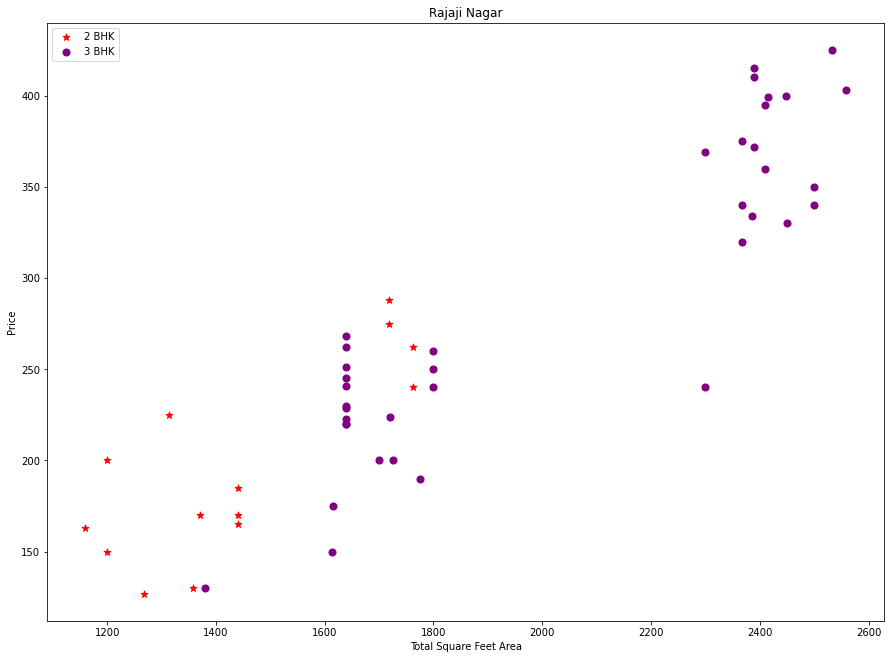

In [39]:
def plot_scatter_chart(df, location):
    bhk2 = df[(df.location == location) & (df.bhk == 2)]
    bhk3 = df[(df.location == location) & (df.bhk == 3)]
    plt.figure(figsize=(15,11))
    plt.scatter(bhk2.total_sqft, bhk2.price, marker="*", color="red", label="2 BHK", s=50)
    plt.scatter(bhk3.total_sqft, bhk3.price, color="purple", label="3 BHK", s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price")
    plt.title(location)
    plt.legend()

plot_scatter_chart(df, 'Rajaji Nagar')

There are some points which signifies that 2 BHK homes are costlier than the 3 BHK homes (red stars above purple dots) which is impractical and have to be removed.

In [40]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                "mean" : np.mean(bhk_df['price_per_sqft']),
                "std" : np.std(bhk_df['price_per_sqft']),
                "count" : bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(int(bhk)-1)
            if stats and stats['count'] > 5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft < stats['mean']].index.values)
    return df.drop(exclude_indices, axis='index')
    
df = remove_bhk_outliers(df)
df.shape

(7393, 6)

This function is basically ignoring the data points where the price is less than the lower bhk apartment's mean price.

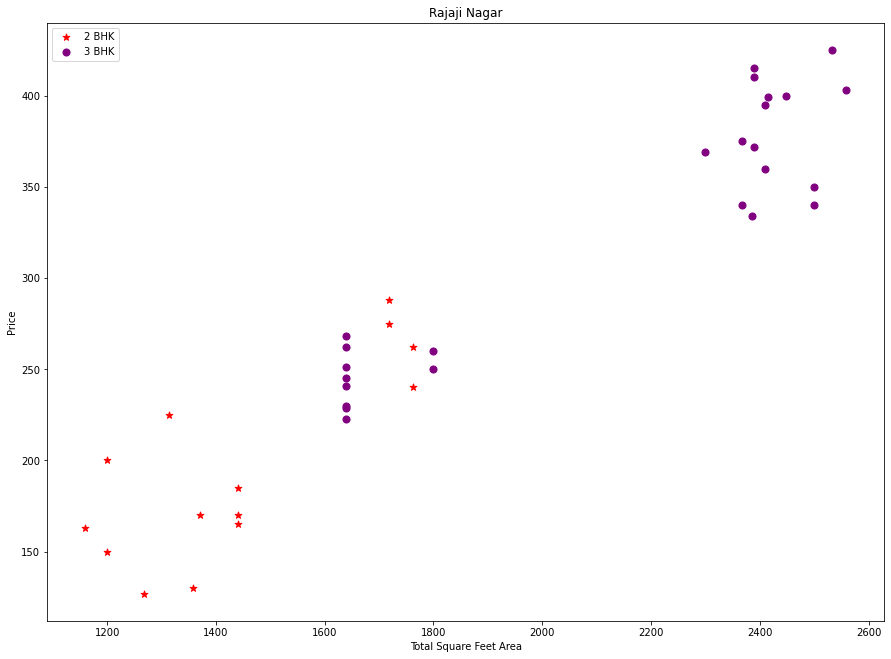

In [41]:
plot_scatter_chart(df, 'Rajaji Nagar')

There is a clear difference here as all the irregular point have been cleared.

Text(0, 0.5, 'Count')

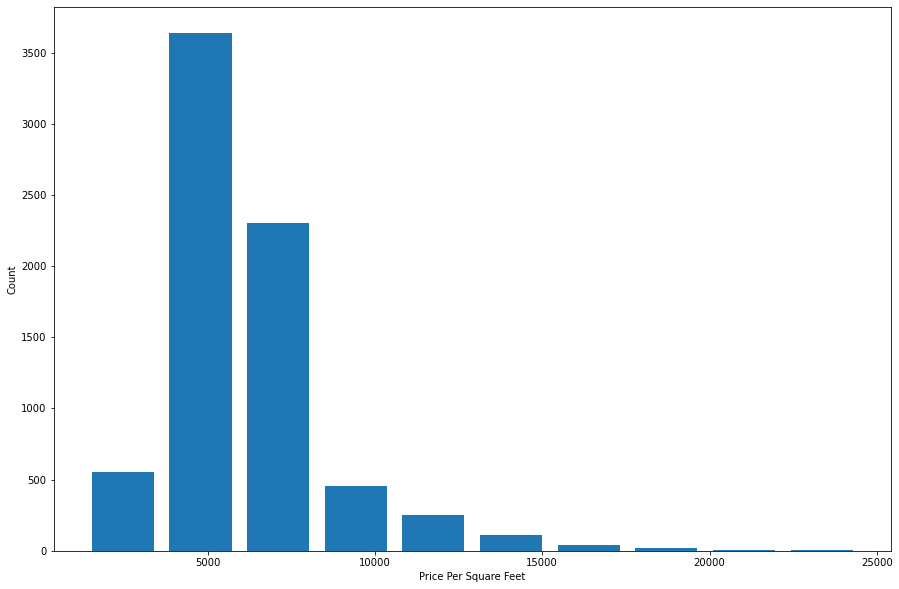

In [42]:
mpl.rcParams['figure.figsize'] = (15, 10)
plt.hist(df.price_per_sqft, rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

Bell Curve (Normal distribution)

In [43]:
df.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6., 14.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'Count')

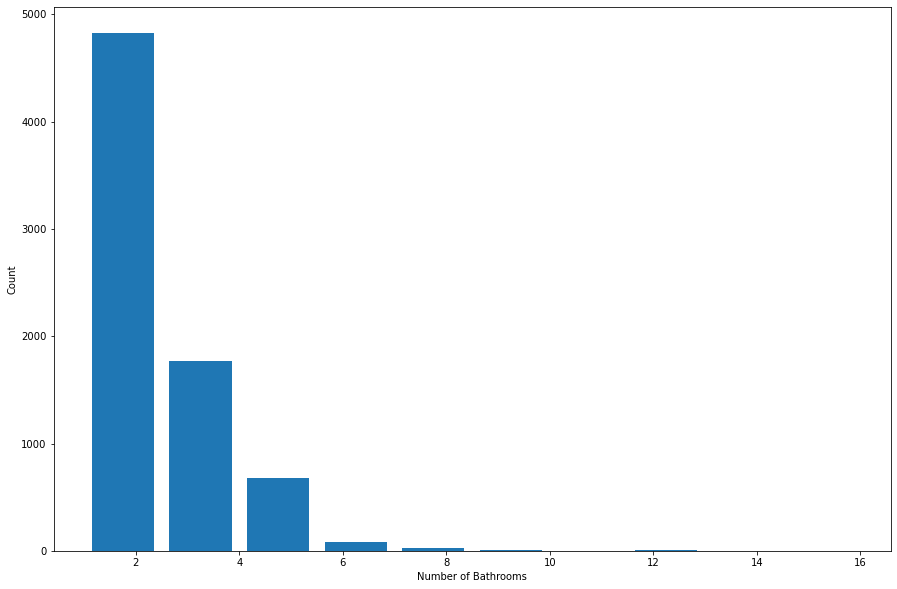

In [44]:
plt.hist(df.bath, rwidth=0.8)
mpl.rcParams['figure.figsize'] = (15, 10)
plt.xlabel("Number of Bathrooms")
plt.ylabel("Count")

In [45]:
df = df[df.bath < df.bhk + 2]  
df.shape

(7315, 6)

Removing all the datapoints where the number of bathrooms are very high compared to the bedrooms.

As we removed most of the outliers, price_per_sqft is no longer needed, hence dropping it. 

In [46]:
df = df.drop(['price_per_sqft'], axis='columns')
df.head()

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3
3,1st Block Jayanagar,1200.0,2.0,130.0,3
4,1st Block Jayanagar,1235.0,2.0,148.0,2


# One Hot Encoding

It's process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

Here, the only categorical value is location.
So, each unique location is converted to a column where the categorical value represents the numerical value of the entry in the dataset.

In [47]:
dummies = pd.get_dummies(df, 'location')
dummies.head()

,total_sqft,bath,price,bhk,location_1st Block Jayanagar,location_1st Block Koramangala,location_1st Phase JP Nagar,location_2nd Phase Judicial Layout,location_2nd Stage Nagarbhavi,location_5th Block Hbr Layout,...,location_Vijayanagar,location_Vishveshwarya Layout,location_Vishwapriya Layout,location_Vittasandra,location_Whitefield,location_Yelachenahalli,location_Yelahanka,location_Yelahanka New Town,location_Yelenahalli,location_Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
df = dummies.drop('location_Other', axis='columns')
df.head()

,total_sqft,bath,price,bhk,location_1st Block Jayanagar,location_1st Block Koramangala,location_1st Phase JP Nagar,location_2nd Phase Judicial Layout,location_2nd Stage Nagarbhavi,location_5th Block Hbr Layout,...,location_Vijayanagar,location_Vishveshwarya Layout,location_Vishwapriya Layout,location_Vittasandra,location_Whitefield,location_Yelachenahalli,location_Yelahanka,location_Yelahanka New Town,location_Yelenahalli,location_Yeshwanthpur
0,2850.0,4.0,428.0,4,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,194.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,235.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,130.0,3,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,148.0,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
df.shape

(7315, 258)

In [50]:
X = df.drop('price', axis='columns')
X.head()

,total_sqft,bath,bhk,location_1st Block Jayanagar,location_1st Block Koramangala,location_1st Phase JP Nagar,location_2nd Phase Judicial Layout,location_2nd Stage Nagarbhavi,location_5th Block Hbr Layout,location_5th Phase JP Nagar,...,location_Vijayanagar,location_Vishveshwarya Layout,location_Vishwapriya Layout,location_Vittasandra,location_Whitefield,location_Yelachenahalli,location_Yelahanka,location_Yelahanka New Town,location_Yelenahalli,location_Yeshwanthpur
0,2850.0,4.0,4,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1630.0,3.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1875.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1200.0,2.0,3,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1235.0,2.0,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
y = df.price
y.head()

0    428.0
1    194.0
2    235.0
3    130.0
4    148.0
Name: price, dtype: float64

# Model building

## Train, Test and Split

Sklearn provides the train_test_split module which, as the name says splits the dataset into training and testing data.

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(5852, 257) (1463, 257) (5852,) (1463,)


## Model training

We are using Linear Regression to train our data.

In [53]:
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train, y_train)
linear_reg_model.score(X_test, y_test)

0.8527962045727558

## Cross Validation

It a technique in which we train our model using the subset of the data-set and then evaluate using the complementary subset of the data-set.

In [54]:
cv = ShuffleSplit(test_size=0.25, n_splits=5)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.85646048, 0.87137044, 0.79990311, 0.85059563, 0.78325333])

## Hyper Parameter Tuning

### Grid Search CV

It is a process that searches exhaustively through a manually specified subset of the hyperparameter space of the targeted algorithm. 

In [55]:
def find_the_best_model(X, y):
    model_parameters = {
        'Linear Regression' : {
            'model' : LinearRegression(),
            'params' : {
                'normalize' : [True, False]
            }
        },
        'Lasso Regression' : {
            'model' : Lasso(),
            'params' : {
                'alpha' : [1, 10, 50, 100],
                'selection' : ['cyclic', 'random']
            }
        },
        'Ridge Regression' : {
            'model' : Ridge(),
            'params' : {
                'alpha' : [1, 10, 50, 100],
                'solver' : ['auto', 'lsqr', 'sparse_cg', 'sag', 'saga']
            }
        },
        'Decision Tree Regressor' : {
            'model' : DecisionTreeRegressor(),
            'params' : {
                'criterion' : ['mse', 'friedman_mse', 'mae', 'poisson'],
                'splitter' : ['best', 'random']
            }
        }
    }
    scores = []
    for model, mp in model_parameters.items() :
        gs = GridSearchCV(mp['model'], mp['params'], cv=cv, return_train_score=False)
        gs.fit(X, y)
        scores.append({
            'Model' : model,
            'Best Score' : gs.best_score_,
            'Best Parameter' : gs.best_params_
        })
    
    return pd.DataFrame(scores, columns=['Model', 'Best Score', 'Best Parameter'])

In [56]:
score_df = find_the_best_model(X, y)

score_df

,Model,Best Score,Best Parameter
0,Linear Regression,0.819950,{'normalize': False}
1,Lasso Regression,0.716013,"{'alpha': 1, 'selection': 'random'}"
2,Ridge Regression,0.847764,"{'alpha': 1, 'solver': 'auto'}"
3,Decision Tree Regressor,0.689248,"{'criterion': 'mae', 'splitter': 'random'}"


As we can see, Ridge Regression turns out to be the best model for our data with a score slightly greater than Linear Regression.



So, we are again training our data using Ridge Regression with it's best parameters.

In [57]:
ridge_model = Ridge(alpha=1, solver='auto')
ridge_model.fit(X_train, y_train)
ridge_model.score(X_train, y_train)

0.8608783425411067

The score is in fact better than the Linear Regression's score.

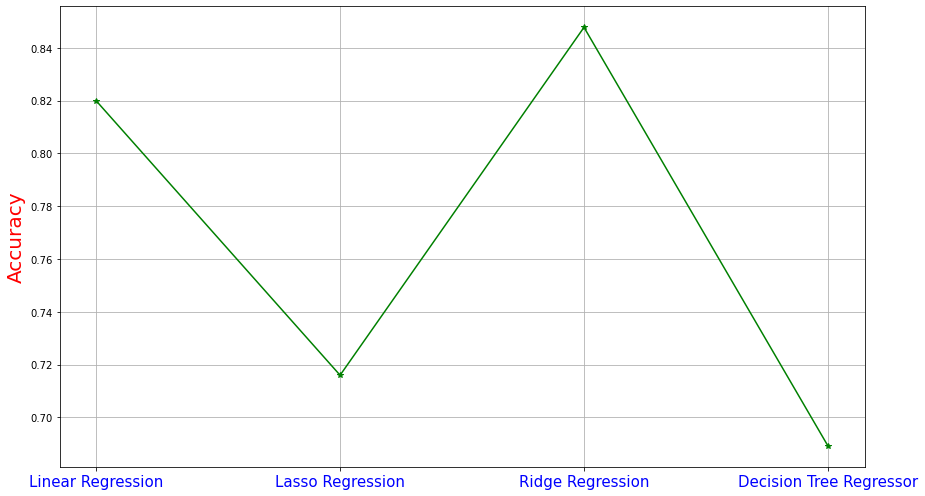

In [58]:
plt.figure(figsize = (13, 7)) 
plt.plot(score_df['Model'], score_df['Best Score'], marker="*" , color="green")
plt.ylabel("Accuracy", color="red", fontsize=20 )
plt.xticks(color="blue", fontsize=15) 
plt.grid(True)
plt.tight_layout()
plt.savefig("best_model.png")
plt.show()

## Prediction

In [59]:
X.columns

Index(['total_sqft', 'bath', 'bhk', 'location_1st Block Jayanagar',
       'location_1st Block Koramangala', 'location_1st Phase JP Nagar',
       'location_2nd Phase Judicial Layout', 'location_2nd Stage Nagarbhavi',
       'location_5th Block Hbr Layout', 'location_5th Phase JP Nagar',
       ...
       'location_Vijayanagar', 'location_Vishveshwarya Layout',
       'location_Vishwapriya Layout', 'location_Vittasandra',
       'location_Whitefield', 'location_Yelachenahalli', 'location_Yelahanka',
       'location_Yelahanka New Town', 'location_Yelenahalli',
       'location_Yeshwanthpur'],
      dtype='object', length=257)

In [60]:
def predict_price(location, sqft, bath, bhk) :
    location = 'location_' + location
    loc_index = np.where(X.columns == location)[0][0]
    
    lst = np.zeros(len(X.columns))
    lst[0] = sqft
    lst[1] = bath
    lst[2] = bhk
    if loc_index > 2 :
        lst[loc_index] = 1
        
    return ridge_model.predict([lst])[0]

This function predicts the price of a house provided location, square feet area, number of bathrooms and BHK.

In [61]:
predict_price('1st Phase JP Nagar', 1000, 2, 2)

86.18589604153352

In [62]:
predict_price('1st Phase JP Nagar', 1000, 3, 3)

90.9431825557462

In [63]:
predict_price('Yelenahalli', 700, 1, 2)

7.4315454303538075

In [64]:
predict_price('Rajaji Nagar', 1000, 2, 2)

224.1543094596186

### Exporting Dataset to CSV 

In [65]:
df.to_csv('final_dataset.csv')

### Saving model

In [66]:
import pickle

with open('prediction_model.pickle', 'wb') as file :
    pickle.dump(ridge_model, file)